<a href="https://colab.research.google.com/github/polrgn/deep_learning_facial_point_detection/blob/main/facial_points_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [ ]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time
import random

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

--2020-12-04 11:38:15--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2020-12-04 11:38:15--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb89ab18395f14e0fe1a1345dde.dl.dropboxusercontent.com/cd/0/inline/BEYWCmzLZHLw4BAi-buVS_qA8NRTgl8aL12chm3L7r2dM0SZrrxfeq9ZnbTWMPgrf_sSv4bBo9f2thzwNlr5cQ8BOo92MnEoH5ek3WI1IhjeDRLPgz9v32-eAMyN_FQTzbk/file# [following]
--2020-12-04 11:38:15--  https://ucb89ab18395f14e0fe1a1345dde.dl.dropboxusercontent.com/cd/0/inline/BEYWCmzLZHLw4BAi-buVS_qA8NRTgl8aL12chm3L7r2dM0SZrrxfeq9ZnbTWMPgrf_sSv4bBo9f2thzwNlr5cQ8BOo92MnEoH5ek3WI1IhjeDRLPgz9v32-eAMyN_F

I had to use a copy of the datasets saved on my Google drive because the source link stopped working. FTRAIN, FTEST and FLOOKUP variables are changed accordingly below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y


def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    x = x.reshape(96,96)
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# Funtion to plot multiple samples

def plot_multsamples(x, y,axis):
    """
    Plots a single sample image with keypoints on top.   
    """
    x = x.reshape(96,96)
    axis.imshow(x, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

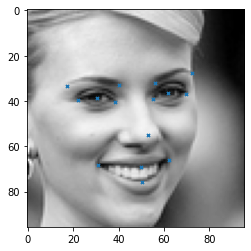

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

# Checking the shape of the train, test and validation arrays
print(X.shape)
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(2140, 96, 96)
(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


# Data augmentation

This section features a series of functions to alter a single image: top-down flip, rotation, change of brightness, shift. They are inspired by Balraj Ashwath's [notebook](https://www.kaggle.com/balraj98/data-augmentation-for-facial-keypoint-detection) in Kaggle's competition on Facial Keypoint Detection. 

I have adapted Ashwath's code to alter a single image and not an entire array, be consistent with the scaling applied in the loading of the data and randomly choose the transformation applied (instead of adding a transformed copy of the image for each possible transformation). The functions below sort the rotation angle (-12º or 12º), brightness alteration factor (0.6 or 1.2) and the shift ((-6,6), (6,-6) or (6,6)).

### Function to flip images

In [ ]:
def left_right_flip_single(image, keypoints):
    flipped_keypoints = []
    # if random.choices([True, False])[0]:
    #     flipped_image = np.fliplr(image) # Flip column-wise (axis=2)
    #     for idx in range(0,len(keypoints)): 
    #         if idx%2==0:
    #           flipped_keypoints.append(-keypoints[idx])
    #         else:
    #           flipped_keypoints.append(keypoints[idx])
    # else:
    flipped_image = np.flipud(image) # Flip column-wise (axis=2)
    for idx in range(0,len(keypoints)): 
        if idx%2==1:
          flipped_keypoints.append(-keypoints[idx])
        else:
          flipped_keypoints.append(keypoints[idx])
    return flipped_image, np.asarray(flipped_keypoints)

flipped_x_train1, flipped_y_train1 = left_right_flip_single(x_train[1], y_train[1])

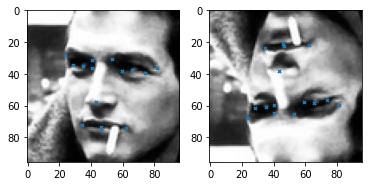

In [ ]:
# Example
fig, (ax1, ax2) = pyplot.subplots(1, 2)
plot_multsamples(x_train[1], y_train[1],ax1)
plot_multsamples(flipped_x_train1, flipped_y_train1,ax2)

### Function to rotate images

In [ ]:
import cv2
from math import sin, cos, pi

def rotate_augmentation_single(image, keypoints):
    rotated_image = []
    rotated_keypoints = []
    select_angle = random.choices([angle,-angle],k=1)[0]
    M = cv2.getRotationMatrix2D((48,48), select_angle, 1.0)
    angle_rad = -select_angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
    # For x_train
    rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
    # For y_train
    for idx in range(0,len(keypoints),2):
        # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
        rotated_keypoints.append(48*keypoints[idx]*cos(angle_rad)-48*keypoints[idx+1]*sin(angle_rad))
        rotated_keypoints.append(48*keypoints[idx]*sin(angle_rad)+48*keypoints[idx+1]*cos(angle_rad))
    rotated_keypoints = [x / 48 for x in rotated_keypoints]
            
    return np.reshape(rotated_image,(96,96,1)), np.asarray(rotated_keypoints)
angle = 12
rotated_x_train1, rotated_y_train1 = rotate_augmentation_single(x_train[1], y_train[1])

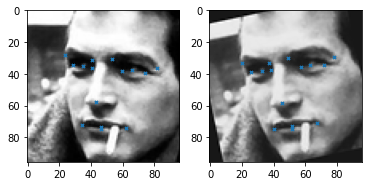

In [ ]:
# Example
fig, (ax1, ax2) = pyplot.subplots(1, 2)
plot_multsamples(x_train[1], y_train[1],ax1)
plot_multsamples(rotated_x_train1, rotated_y_train1,ax2)

### Function to alter the brightness of images

In [ ]:
def alter_brightness_single(image, keypoints):
    brigthness_factor = random.choices([1.2,0.6],k=1)[0]
    altered_brightness_image = np.clip(image*brigthness_factor, 0.0, 1.0)    # Increase of decrease brightness by a factor of 1.2 or 0.6 & clip any values outside the range of [-1,1]
    return altered_brightness_image, keypoints

altered_brightness_x_train1, altered_brightness_y_train1 = alter_brightness_single(x_train[1], y_train[1])

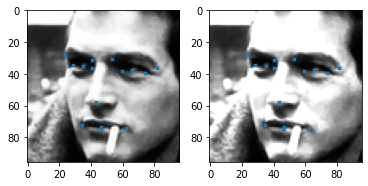

In [ ]:
# Example
fig, (ax1, ax2) = pyplot.subplots(1, 2)
plot_multsamples(x_train[1], y_train[1],ax1)
plot_multsamples(altered_brightness_x_train1, altered_brightness_y_train1,ax2)

### Function to shift images

In [ ]:
def shift_images_single(image, keypoints):
    (shift_x,shift_y) = random.choices([(-shift,shift),(shift,-shift),(shift,shift)],k=1)[0]
    M = np.float32([[1,0,shift_x],[0,1,shift_y]])
    shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
    shifted_keypoints = []
    for idx in range(0,len(keypoints)):
      point = keypoints[idx]*48.+48.
      if idx%2==0:
        shifted_keypoints.append(point+shift_x)
      else:
        shifted_keypoints.append(point+shift_y)
    shifted_keypoints = np.asarray([(x-48)/48 for x in shifted_keypoints])
    if np.all(-1<shifted_keypoints) and np.all(shifted_keypoints<96.0):
      return shifted_image.reshape(96,96,1), shifted_keypoints
    else:
      return image, keypoints

shift = 6

shifted_x_train1, shifted_y_train1 = shift_images_single(x_train[1], y_train[1])

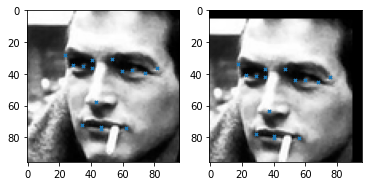

In [ ]:
# Example
fig, (ax1, ax2) = pyplot.subplots(1, 2)
plot_multsamples(x_train[1], y_train[1],ax1)
plot_multsamples(shifted_x_train1, shifted_y_train1,ax2)

### Augmentation of the dataset
During augmentation one or several transformations are applied at random to each image in the training dataset and the transformed image is appended to the training dataset. The set of transformations to apply to each image is determined by a random boolean vector: the random vectors for the first 7 images are printed as ouput. We run one round of augmentations resulting in a training set two times larger than originally.

In [ ]:
def data_augmentation(images,keypoints):
  images_aug = np.copy(images)
  keypoints_aug = np.copy(keypoints)
  for idx in range(0,images.shape[0]):
    #Boolean vector to randomly set wether each transformation should occur
    while True:
      transformations = random.choices([True, False],weights=[1/12,11/12],k=4)
      if sum(transformations) != 0:
        break
    #Print the first six transformation vectors
    if idx <= 6:
      print(transformations)
    if idx == 6:
      print('...')
    #Apply the transformation if True
    if transformations[0]==True:
      images_aug[idx][:], keypoints_aug[idx][:] = left_right_flip_single(images_aug[idx], keypoints_aug[idx])
    
    if transformations[1]==True:
      images_aug[idx][:], keypoints_aug[idx][:] = rotate_augmentation_single(images_aug[idx], keypoints_aug[idx])

    if transformations[2]==True:
      images_aug[idx][:], keypoints_aug[idx][:] = alter_brightness_single(images_aug[idx], keypoints_aug[idx])

    if transformations[3]==True:
      images_aug[idx][:], keypoints_aug[idx][:] = shift_images_single(images_aug[idx], keypoints_aug[idx])
  
    new_image = np.expand_dims(images_aug[idx], 0)
    new_keypoints = np.expand_dims(keypoints_aug[idx], 0)
    # images = np.append(images, new_image, axis=0)
    # keypoints = np.append(keypoints, new_keypoints, axis=0)
  return images_aug, keypoints_aug

# Rotation angle and shift values
angle = 6
shift = 6

#First round of augmentation
x_train_temp, y_train_temp = data_augmentation(x_train,y_train)
x_train_aug = np.append(x_train, x_train_temp, axis=0)
y_train_aug = np.append(y_train, y_train_temp, axis=0)

[False, True, False, False]
[False, False, True, False]
[False, False, False, True]
[True, False, False, False]
[False, False, True, False]
[False, True, False, False]
[True, False, False, False]
...


Example of augmentation. A sample of original images and transformed images during the first round of augmentation.

Shape of x_train: (1498, 96, 96, 1)
Shape of x_train_augmented: (2996, 96, 96, 1)
Shape of y_train: (1498, 30)
Shape of y_train_augmented: (2996, 30)


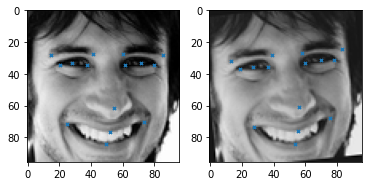

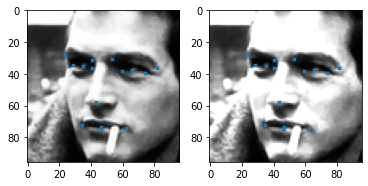

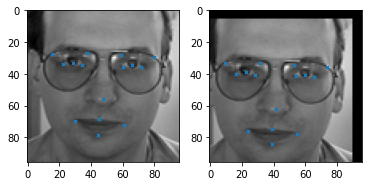

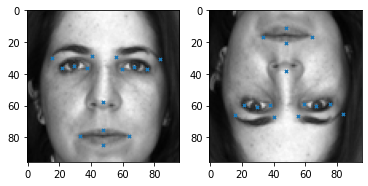

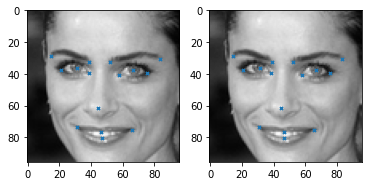

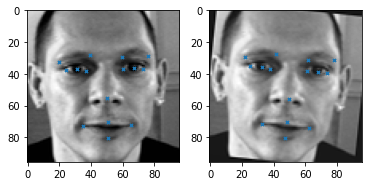

In [ ]:
print("Shape of x_train: {}".format(np.shape(x_train)))
print("Shape of x_train_augmented: {}".format(np.shape(x_train_aug)))
print("Shape of y_train: {}".format(np.shape(y_train)))
print("Shape of y_train_augmented: {}".format(np.shape(y_train_aug)))

for i in range(0,6):
  fig, (ax1, ax2) = pyplot.subplots(1, 2)
  plot_multsamples(x_train[i], y_train[i],ax1)
  plot_multsamples(x_train_aug[i+1498], y_train_aug[i+1498],ax2)

x_train_aug, y_train_aug = shuffle(x_train_aug, y_train_aug, random_state=84)

#Convolutional Neural Network

Our architecture is composed of 5 identical blocks, each of them made of one convolutional layer followed by a max pooling layer. The size of the kernels is identical across all convolutional layers at (3,3). The pool size is also identical across all max pooling layers at (2,2). Activation function used is ReLU. We have two dropout layers with dropout rate 0.5 after the second block and after the fourth block. 

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)       

We fit our convolutional network on the augmented training dataset.

In [ ]:
batch_size = 300
epochs = 900

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(x_train_aug, y_train_aug, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/900
9/9 [==============================] - 1s 76ms/step - loss: 0.2909 - val_loss: 0.3064
Epoch 2/900
9/9 [==============================] - 1s 64ms/step - loss: 0.2324 - val_loss: 0.2800
Epoch 3/900
9/9 [==============================] - 1s 65ms/step - loss: 0.2201 - val_loss: 0.2735
Epoch 4/900
9/9 [==============================] - 1s 65ms/step - loss: 0.2156 - val_loss: 0.2571
Epoch 5/900
9/9 [==============================] - 1s 64ms/step - loss: 0.2128 - val_loss: 0.2453
Epoch 6/900
9/9 [==============================] - 1s 64ms/step - loss: 0.2119 - val_loss: 0.2395
Epoch 7/900
9/9 [==============================] - 1s 65ms/step - loss: 0.2113 - val_loss: 0.2307
Epoch 8/900
9/9 [==============================] - 1s 65ms/step - loss: 0.2108 - val_loss: 0.2265
Epoch 9/900
9/9 [==============================] - 1s 65ms/step - loss: 0.2099 - val_loss: 0.2223
Epoch 10/900
9/9 [==============================] - 1s 65ms/step - loss: 0.2091 - val_loss: 0.2239
Epoch 11/900
9/9 [=

In [ ]:
y_new = model.predict(x_valid)
def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error on validation set: ", rmse_pixel(y_valid, y_new))

Mean pixel error on validation set:  1.3010699


Visual assessment of predictions on validation set

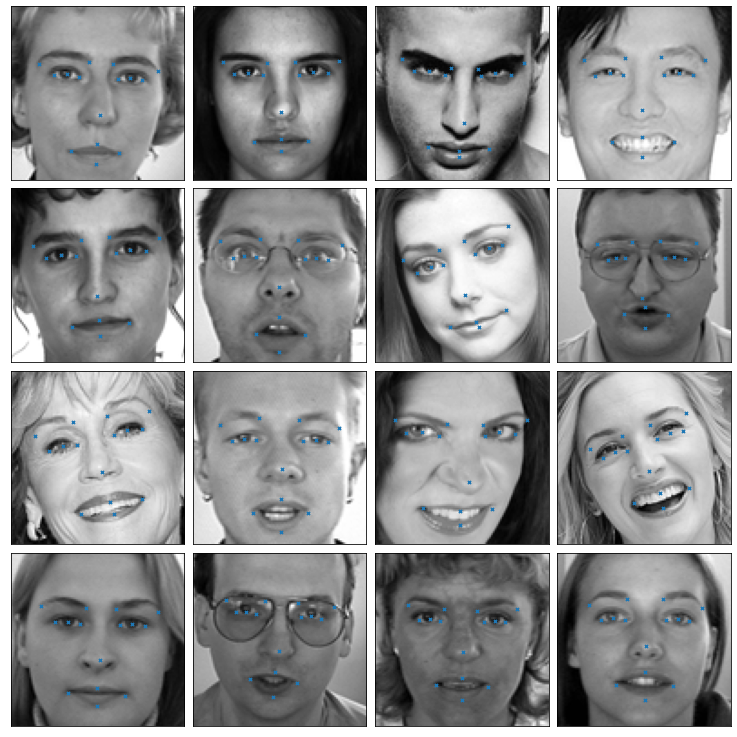

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

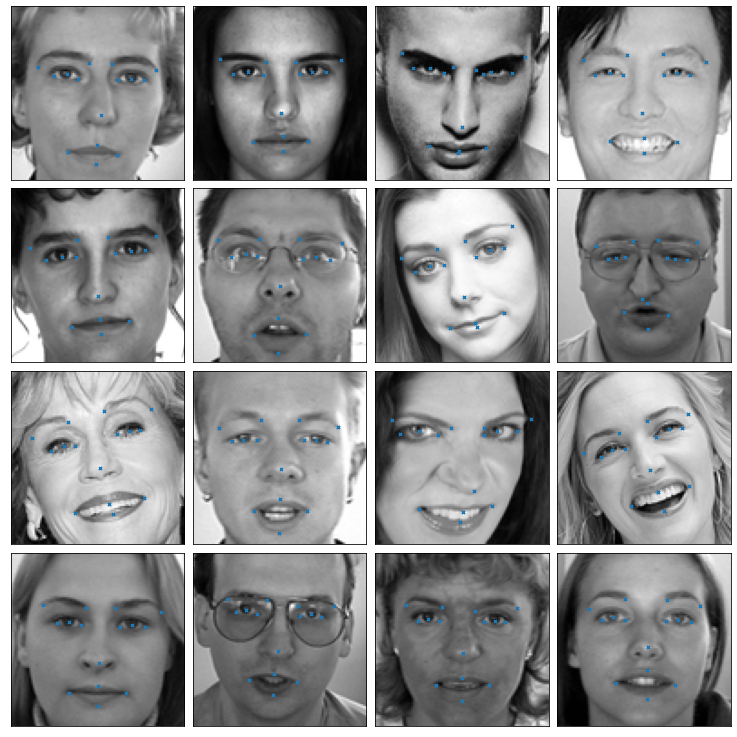

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error on the test set is


In [ ]:
y_new = model.predict(x_test)

print("Mean pixel error on test set: ", rmse_pixel(y_test, y_new))

Mean pixel error on test set:  1.3610508


## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: 

To develop our model we started with working on the architecture: we gradually increased the number of blocks of convolutional layers combined with a max poooling layer until we observe no improvement in the mean pixel error on the validation set. In this process we gradually increased the depth of the network and thus the capacity of the model to handle complexity. 

We then proceeded with adding dropout layers for regularization. In the same fashion, we added dropout layers until observing no improvement in the mean pixel error. Dropout layers help in reducing overfitting. At this stage we had arrived to architecture of the final model.

We then worked on the number of epochs and batch size, increasing both at the same time. The effect has been to slow the learning process of the network: slower but further. We stopped at batch size of 300 and 900 epochs because we did not observe improvements further.

We then augmented the data by altering each image in the dataset and thus obtaining a training set double the original size. The model trained on the augmented data has better generalization properties.

We confirmed our good performance results by running multiple times the entire process from training/validation split to model fiting.